# $$1.\ Data\ Strategy\ and\ Exploratory Data Analysis$$


__Load Modules and CSV__

In [67]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import seaborn as sns


plt.style.use('ggplot')

from seaborn import distplot
import seaborn as sns
from pandas.plotting import scatter_matrix


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

from sklearn.metrics import *
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import binarize
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
import shap
from itertools import combinations

from sklearn.linear_model import *

import warnings
warnings.filterwarnings('ignore')


%pylab inline

pd.set_option('display.max_colwidth', -1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [68]:
kpop_df = pd.read_csv('data/combined_csv.csv', index_col = 0)
kpop_df_copy = kpop_df.copy()

In [69]:
kpop_df['release_date'] = pd.to_datetime(kpop_df['release_date'])
kpop_df['year'] = [i.year for i in kpop_df.release_date]
kpop_df['artist_name'] = [i.lower().replace("'", '') for i in kpop_df.artist_name]

1. Comparison of audio features of blackpink with some kpop groups 

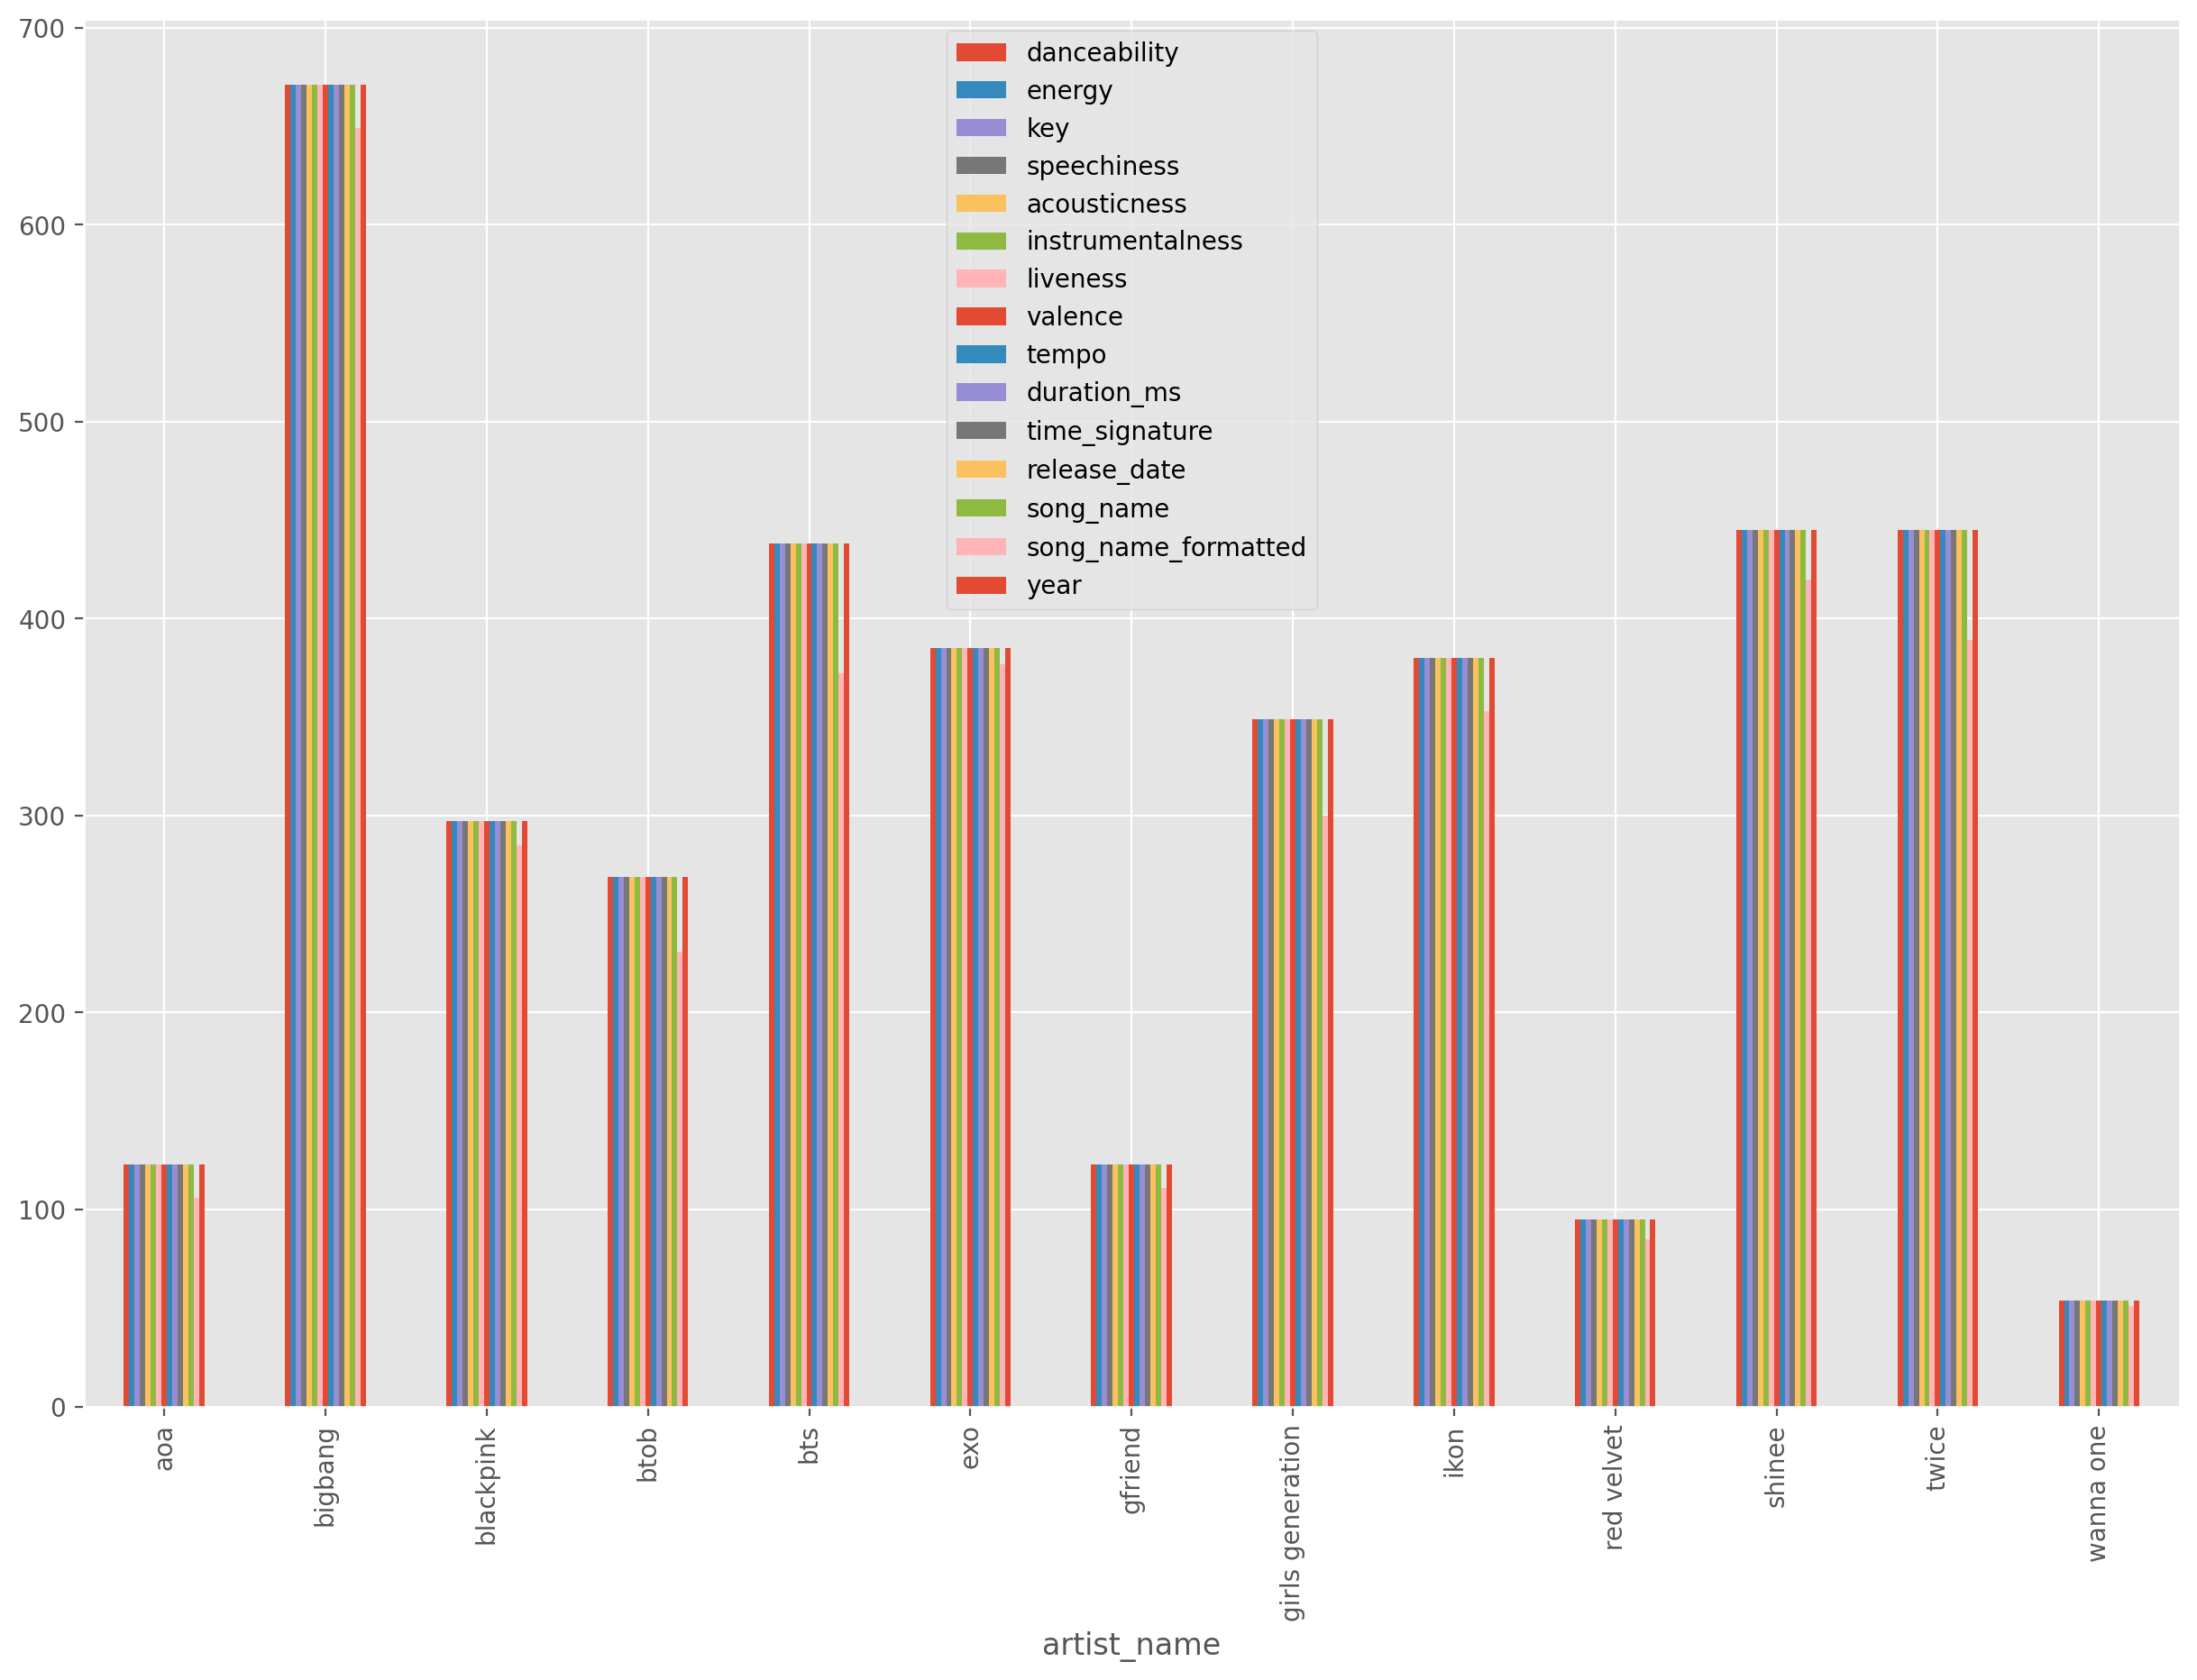

In [70]:
kpop_df.groupby('artist_name').count().plot(kind='bar',figsize=(15,10))

plt.show()

In [71]:
kpop_df['target'] = [1 if i == 'blackpink' else 0 for i in kpop_df.artist_name]
 
kpop_df.corr()['target']

danceability        0.085193
energy             -0.143429
key                 0.001923
speechiness        -0.003775
acousticness       -0.042239
instrumentalness   -0.058454
liveness           -0.066247
valence            -0.028607
tempo               0.014587
duration_ms        -0.097130
time_signature     -0.016528
year                0.378513
target              1.000000
Name: target, dtype: float64

2. Calculation of the mean of the audio features of the groups

In [72]:
kpop_df.groupby('artist_name').agg({'speechiness':'mean', 'instrumentalness':'mean', 'danceability':'mean', 'energy':'mean','acousticness':'mean'}).sort_values('speechiness', ascending = False)

,speechiness,instrumentalness,danceability,energy,acousticness
artist_name,,,,,
bts,0.172844,0.012400,0.601454,0.801566,0.118142
bigbang,0.108219,0.006586,0.582627,0.832900,0.109640
blackpink,0.095616,0.000055,0.675269,0.712017,0.136358
red velvet,0.094951,0.017682,0.668874,0.748158,0.224725
wanna one,0.094881,0.000000,0.616815,0.787222,0.199652
ikon,0.093867,0.028128,0.630211,0.796621,0.191380
exo,0.087405,0.028308,0.618177,0.779132,0.189418
shinee,0.083504,0.014346,0.637085,0.807092,0.143948
twice,0.079760,0.040576,0.720548,0.801283,0.154477


3. The scatter matrix shows that the lower the speechiness, the lower the liveness. The red color reflect individual Blackpink songs and the blue color represent songs from other k-pop groups. Unlike previous analysis through tables, we can't really find the discernment between two target labels through visualization.

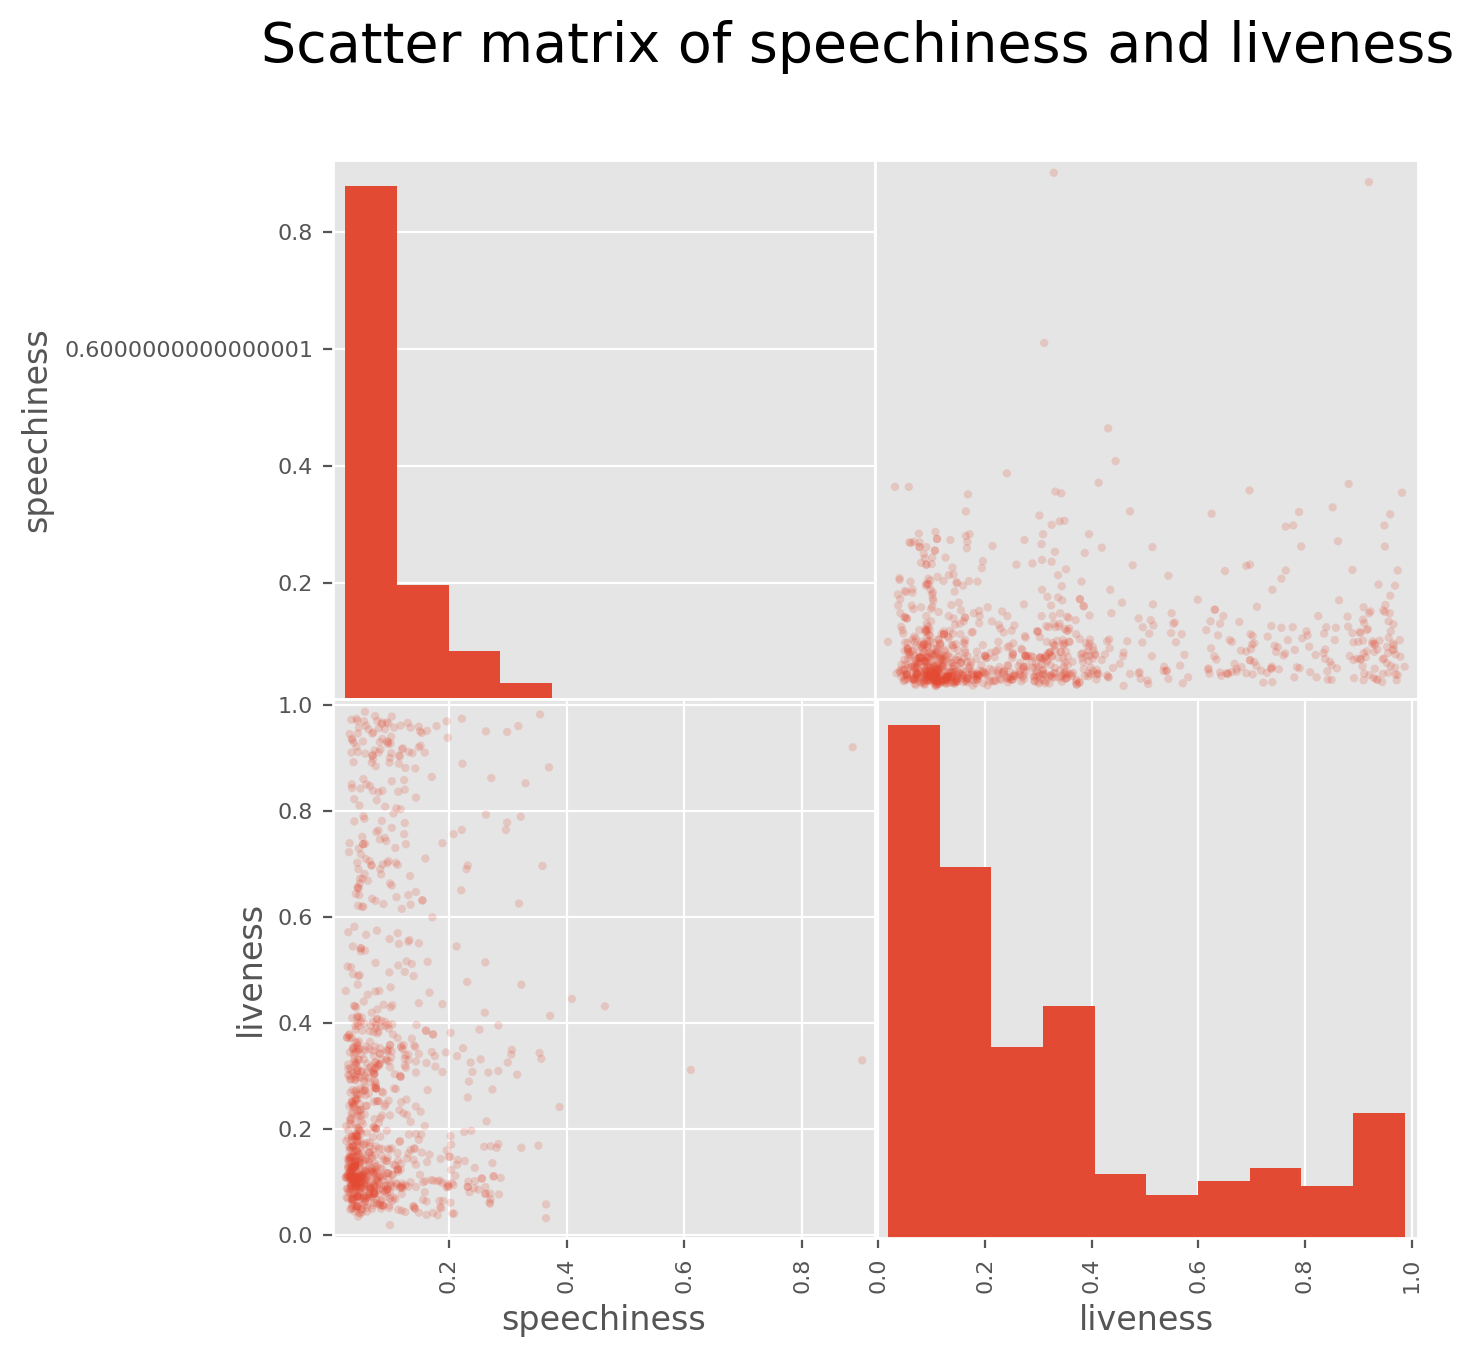

In [73]:
colors = ['red' if ix else 'blue' for ix in kpop_df.target]

scatter_matrix(kpop_df[['speechiness', 'liveness']].sample(1000), alpha = 0.2, figsize = (7,7), diagonal = 'hist');
plt.suptitle('Scatter matrix of speechiness and liveness', size = 20);

4. Blackpink's audio features evolution over the years

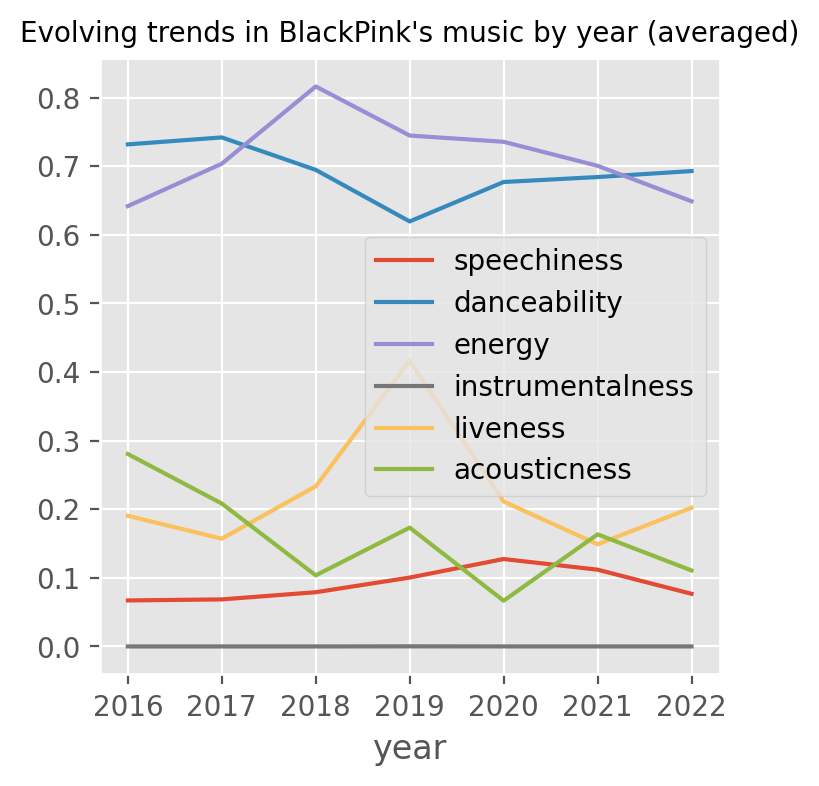

In [74]:
black_grouped = kpop_df[kpop_df.artist_name == 'blackpink']
black_grouped.groupby('year').agg({'speechiness':'mean', 'danceability':'mean', 'energy':'mean', 'instrumentalness':'mean', 'liveness':'mean', 'acousticness':'mean'}).plot(figsize = (4,4));
plt.title('Evolving trends in BlackPink\'s music by year (averaged)', size = 10);

5. Histogram of all features related to songs by BlackPink

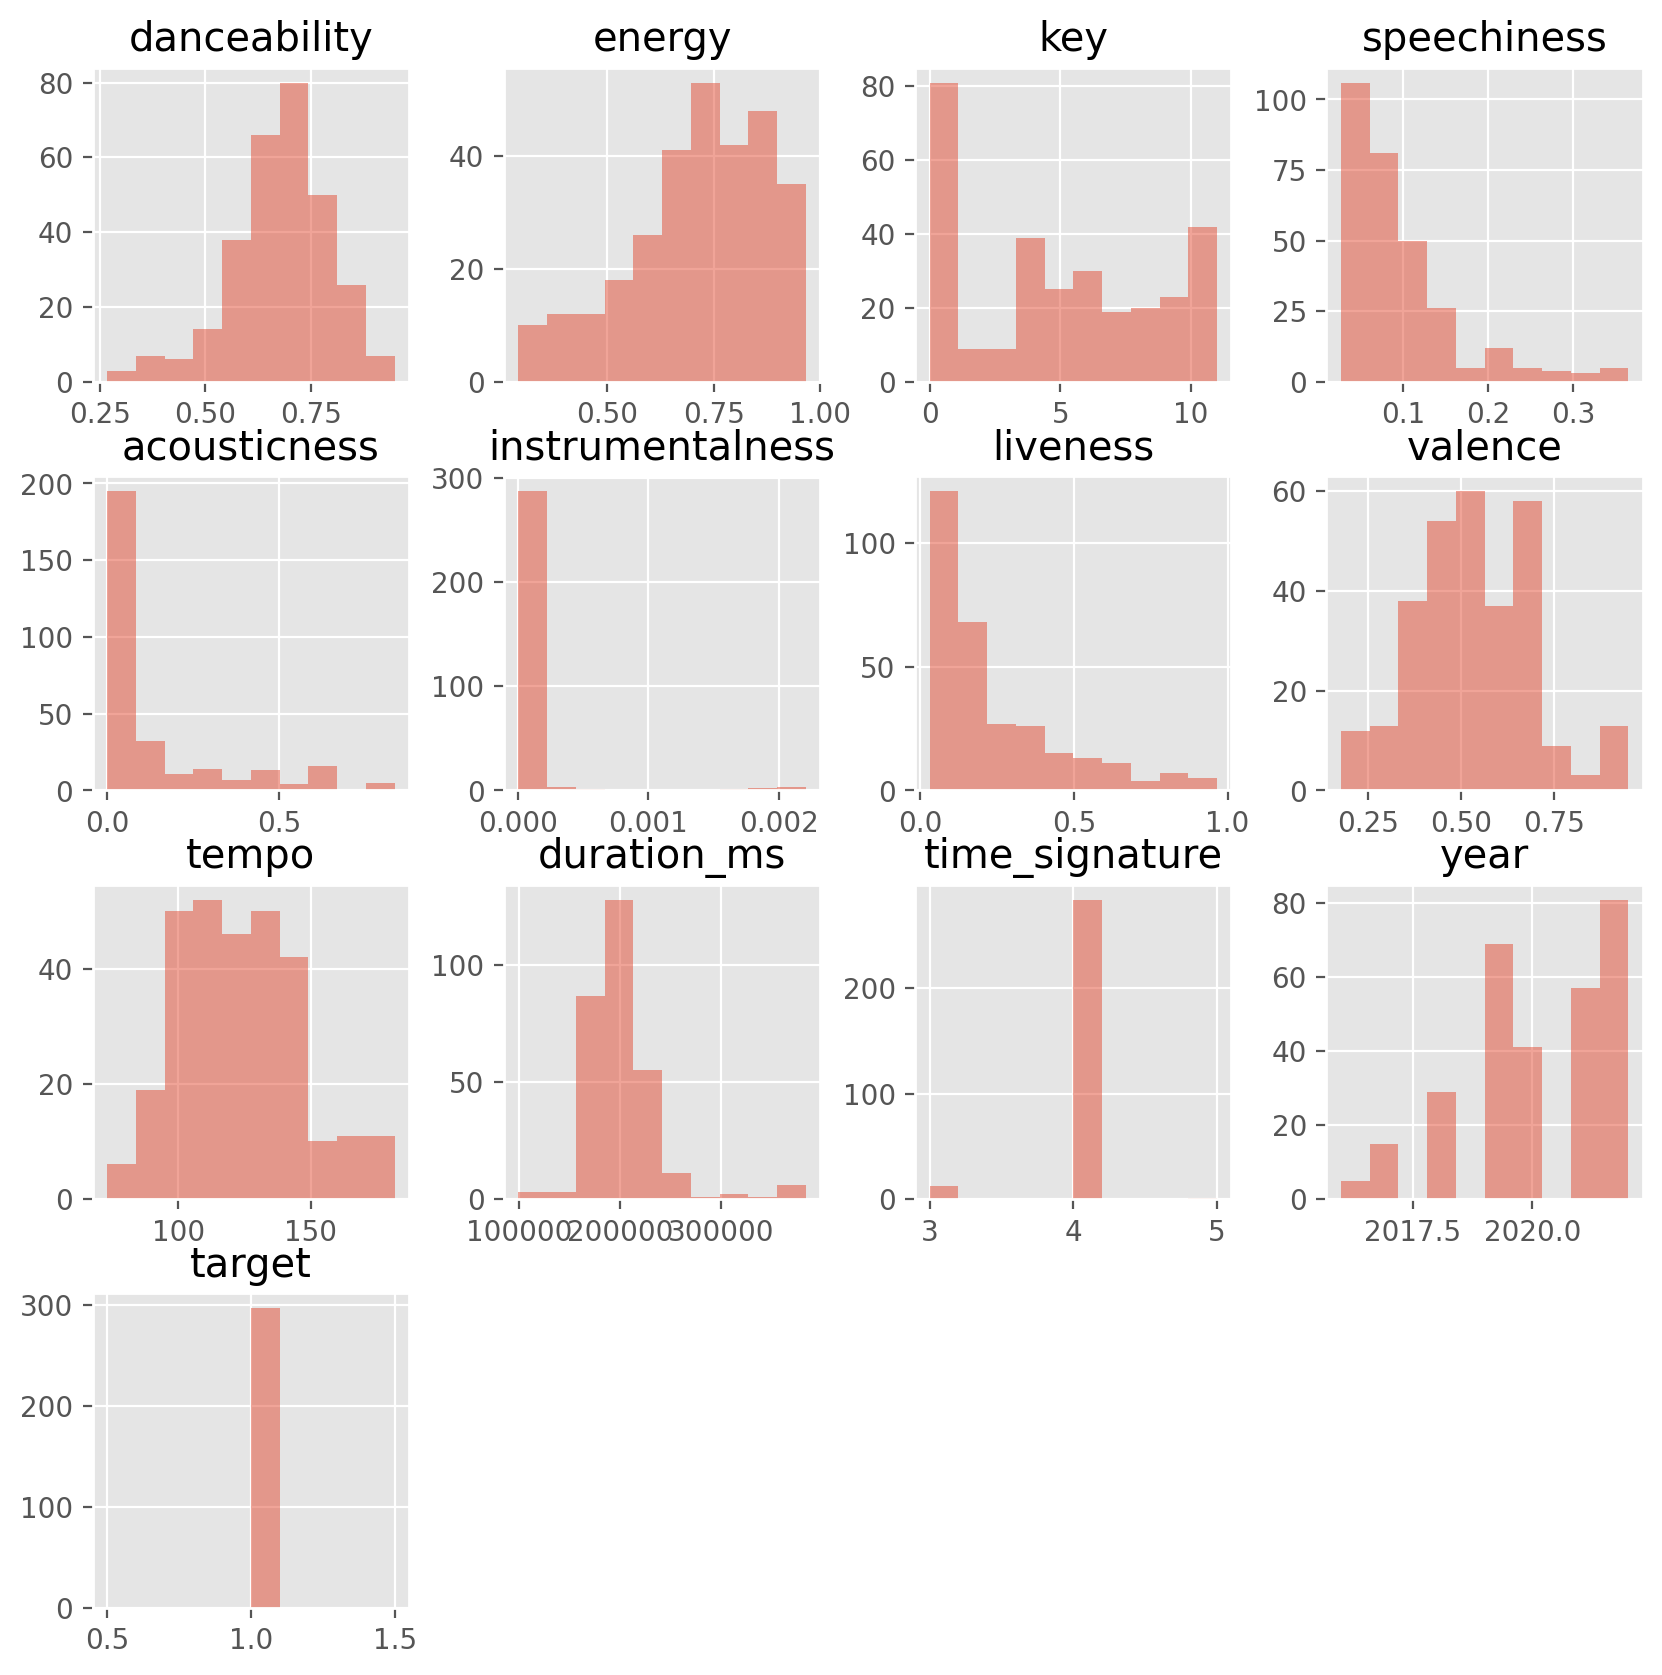

In [75]:

kpop_df[kpop_df.artist_name == 'blackpink']._get_numeric_data().hist(alpha = 0.5, figsize=(10,10));

In [76]:
blackpink_tempo = kpop_df[kpop_df['artist_name'] == 'blackpink']['tempo']  
bigbang_tempo = kpop_df[kpop_df['artist_name'] == 'bigbang']['tempo']  
ikon_tempo = kpop_df[kpop_df['artist_name'] == 'ikon']['tempo']
bts_tempo = kpop_df[kpop_df['artist_name'] == 'bts']['tempo']

6. Distribution of musical tempo of Blackpink, Bigbang, BTS, and Ikon.

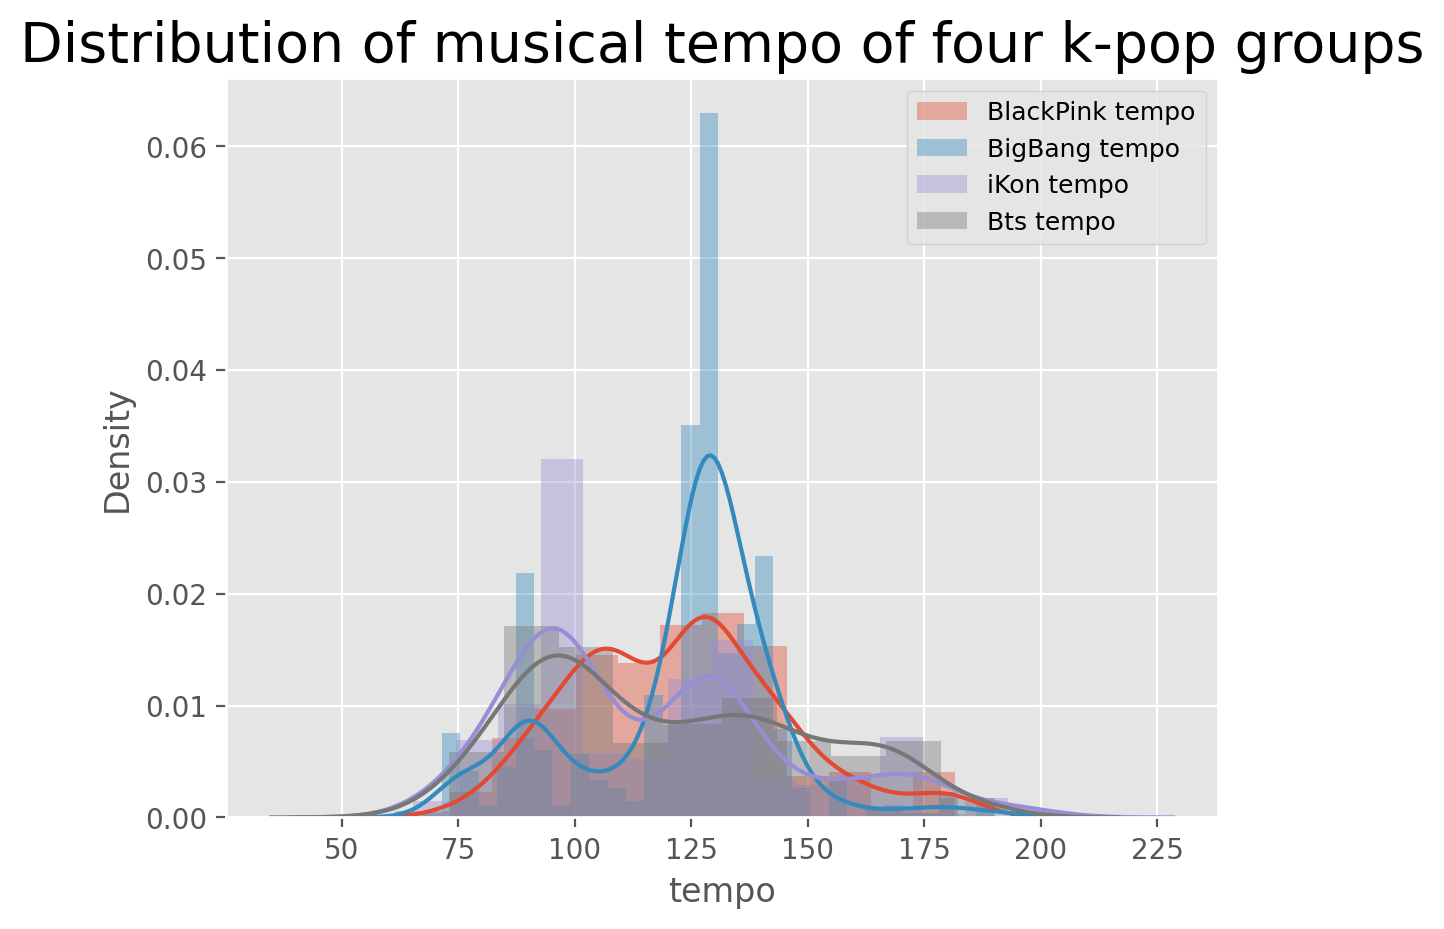

In [77]:
sns.distplot(blackpink_tempo, label = 'BlackPink tempo');
sns.distplot(bigbang_tempo, label = 'BigBang tempo');
sns.distplot(ikon_tempo, label = 'iKon tempo');
sns.distplot(bts_tempo, label = 'Bts tempo');
plt.title('Distribution of musical tempo of four k-pop groups', size = 20)
plt.legend(prop = {'size': 9});

# $$2.\ Modeling$$

## 2.1 Baseline Modeling for a Blackpink Classifier

We choosed three popular (tree-based) boosting algorithms.

- LightGBM Classifier 
- Gradientboost Classifier
- RandomForest Classifier

We also used a oversampling technique (**SMOTE**) to address the class imbalance issue.

In [78]:
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

import shap
from itertools import combinations


In [79]:
kpop_df_copy = kpop_df.copy()
kpop_df = kpop_df.drop(['artist_name','release_date','year','song_name','song_name_formatted'], 1)

7. Split 80% of the dataset for training and 20% for testing.

In [80]:
X_train, X_validation, y_train, y_validation = train_test_split(kpop_df.iloc[:,:-1], kpop_df.target, train_size=0.2)

X_train_lgbm = pd.get_dummies(X_train)
X_validation_lgbm = pd.get_dummies(X_validation)

X_train_lgbm.reset_index(inplace = True)
X_validation_lgbm.reset_index(inplace = True)

In [81]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)

X_train_smote, y_train_smote = sm.fit_resample(X_train_lgbm, y_train.ravel())
X_validation_smote, y_validation_smote = sm.fit_resample(X_validation_lgbm, y_validation.ravel())

X_train_smote = pd.DataFrame(X_train_smote, columns = X_train_lgbm.columns).set_index('index')
X_validation_smote = pd.DataFrame(X_validation_smote, columns = X_validation_lgbm.columns).set_index('index')

8. Calculating the ROC AUC score with three different machine learning algorithm.

In [82]:
lgb_c = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.01,
                                   reg_alpha = 0.1, reg_lambda = 0.1, silent=True,
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
lgb_c.fit(X_train_smote, y_train_smote,
           eval_set=[(X_validation_smote, y_validation_smote)],
           early_stopping_rounds=100,
eval_metric='auc',
verbose=200,)


[200]	valid_0's auc: 0.87616	valid_0's binary_logloss: 0.475395


LGBMClassifier(class_weight='balanced', learning_rate=0.01, n_estimators=10000,
               objective='binary', random_state=50, reg_alpha=0.1,
               reg_lambda=0.1, silent=True, subsample=0.8)

In [83]:
gbc = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01)
gbc.fit(X_train_smote, y_train_smote)

validation_pred_proba_grad = gbc.predict_proba(X_validation_smote)
roc_auc_score(y_validation_smote, validation_pred_proba_grad[:,1])

0.8987780323513295

In [84]:
rf = RandomForestClassifier()
rf.fit(X_train_smote,y_train_smote)

validation_pred_proba_grad = rf.predict_proba(X_validation_smote)
roc_auc_score(y_validation_smote, validation_pred_proba_grad[:,1])

0.8860892063977337

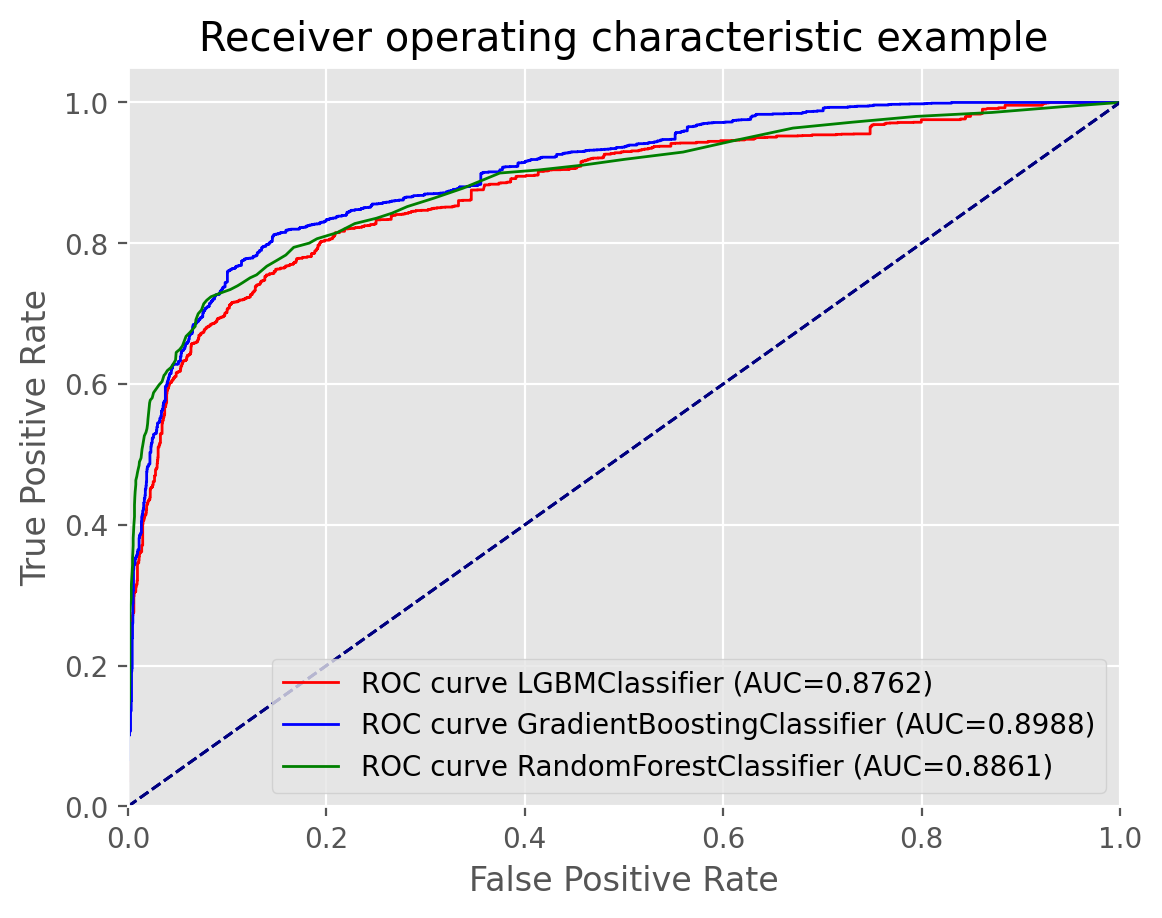

In [85]:
def plot_roc(model, X_validation, y_validation,  color):
    validation_pred_proba = model.predict_proba(X_validation)
    fpr, tpr, thresholds = roc_curve(y_validation, validation_pred_proba[:,1])
    auc = roc_auc_score(y_validation, validation_pred_proba[:,1])

    plt.plot(fpr, tpr, color=color,lw=1, label='ROC curve {} (AUC={:0.4f})'.format(model.__class__.__name__,auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right");
    
plot_roc(lgb_c, X_validation_smote, y_validation_smote, 'r')
plot_roc(gbc, X_validation_smote, y_validation_smote, 'b')
plot_roc(rf, X_validation_smote, y_validation_smote, 'g')

>Each model is performing phenomenally in terms of AUC score. Random forest performs the best.

## 2.2 Feature Importance

- Feature Importance LGBMClassifier

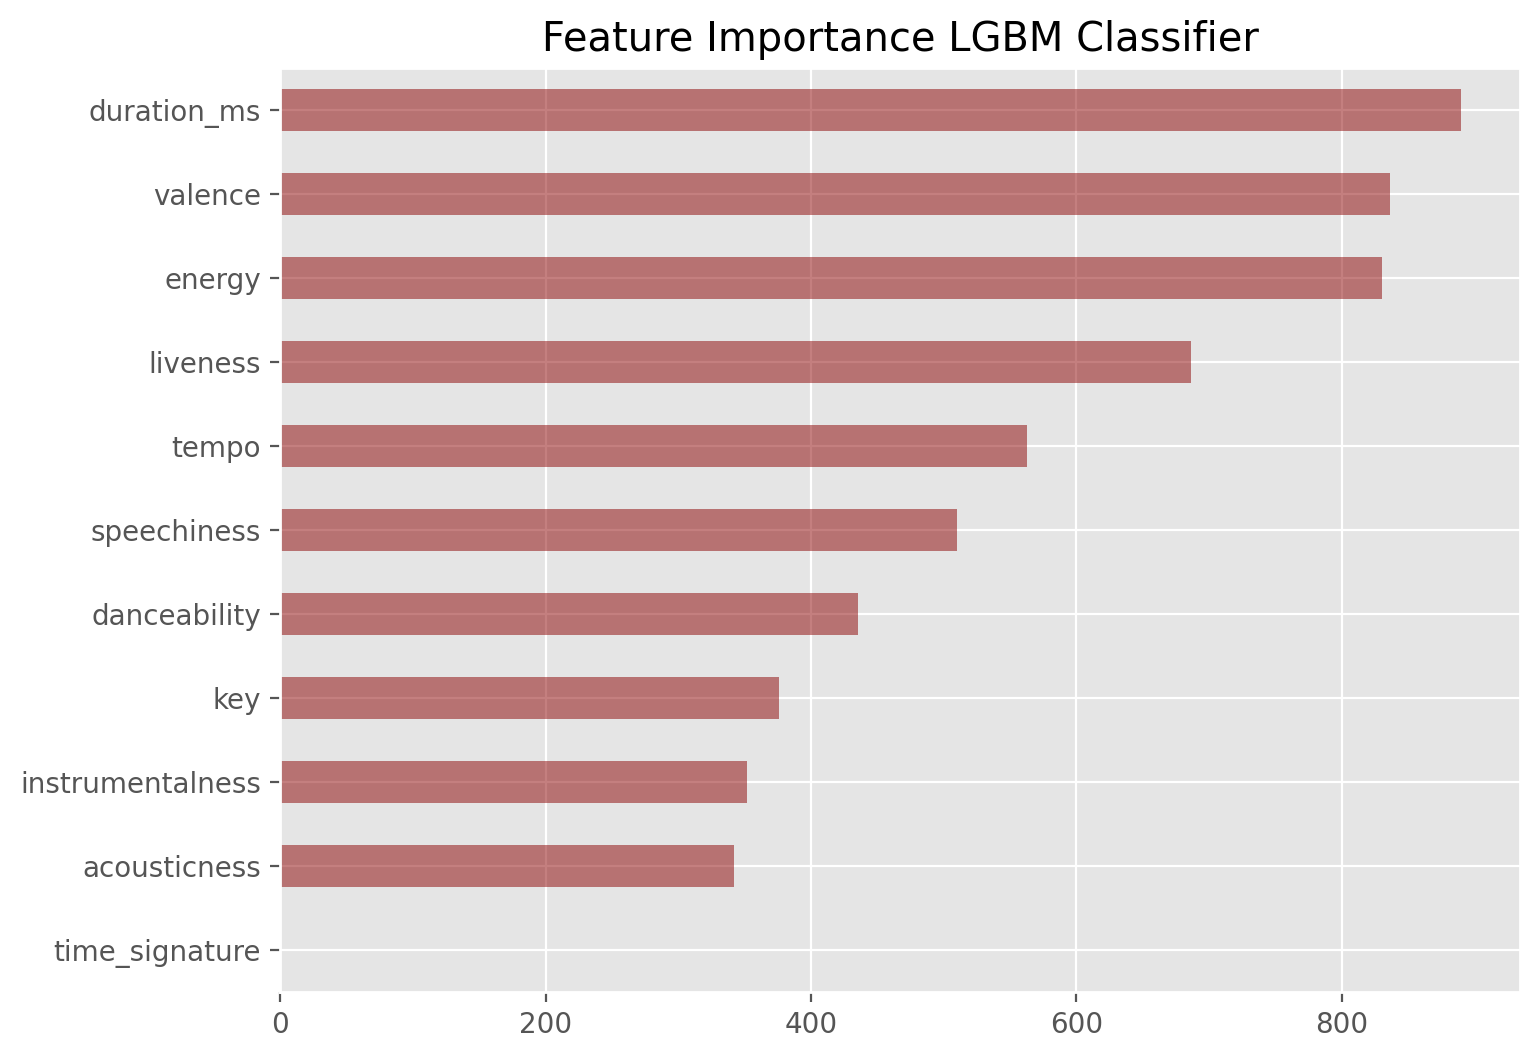

In [86]:
importance_series = pd.Series(data=lgb_c.feature_importances_, index=X_validation_smote.columns)
ax = importance_series.sort_values().plot(kind='barh',width=0.5, figsize=(8,6), color='darkred', alpha=0.5)
ax.set_title('Feature Importance LGBM Classifier');

- Feature Importance GradientBoost Classifier

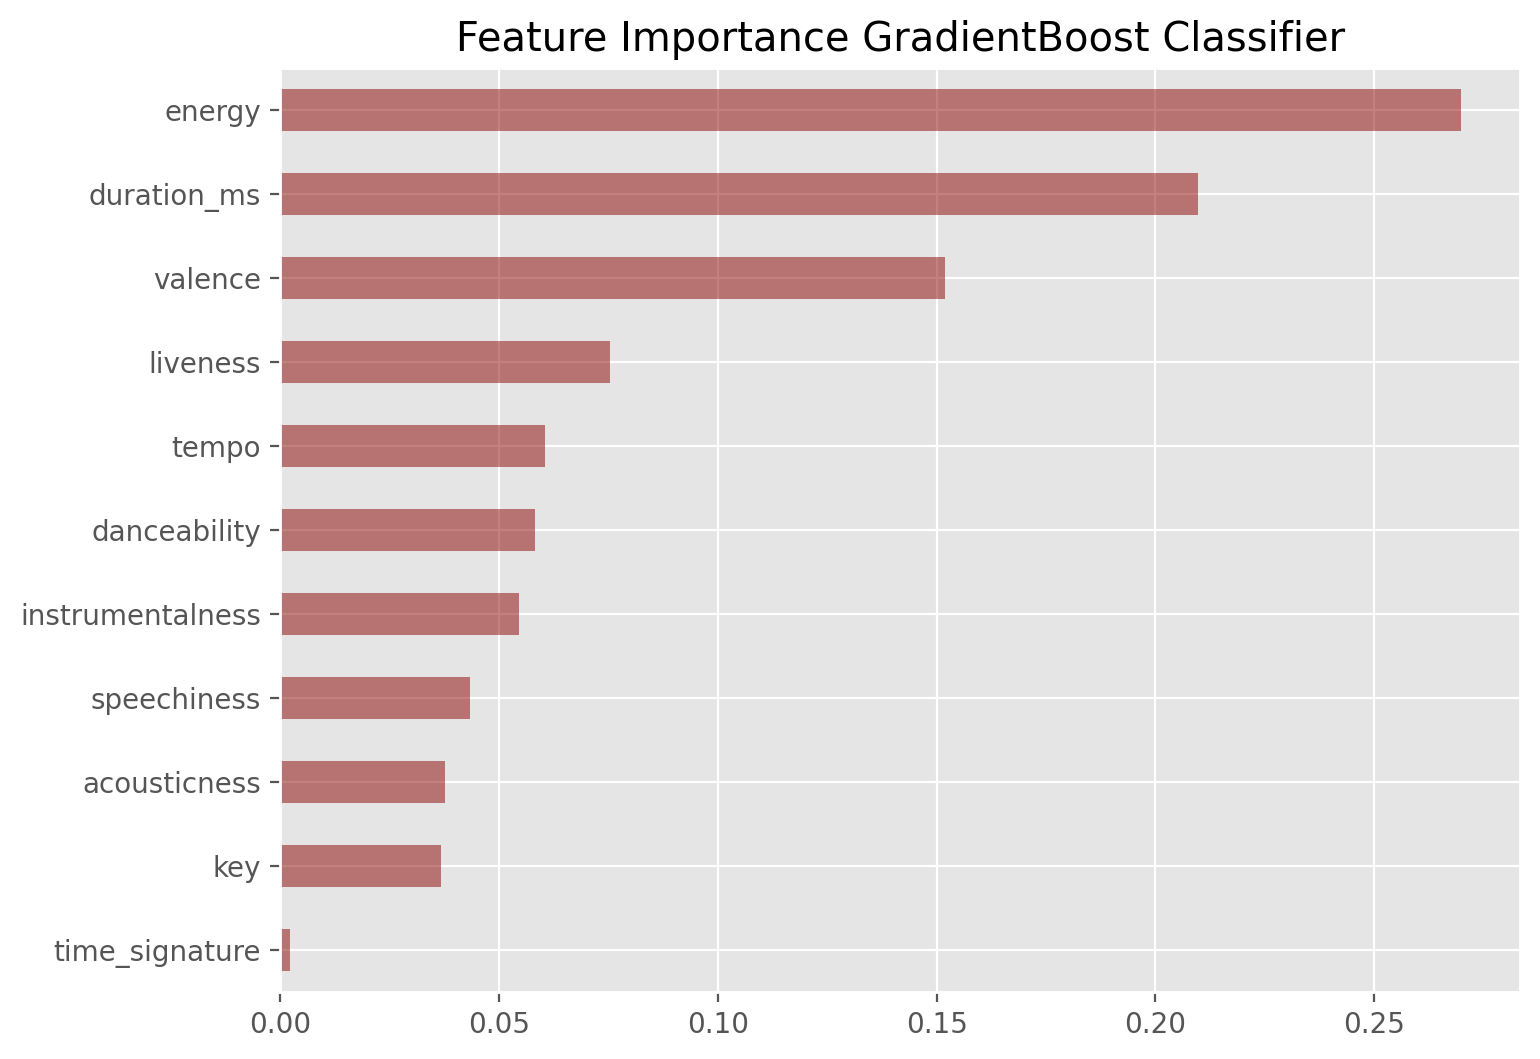

In [87]:
importance_series = pd.Series(data=gbc.feature_importances_, index=X_validation_smote.columns)
ax = importance_series.sort_values().plot(kind='barh',width=0.5, figsize=(8,6), color='darkred', alpha=0.5)
ax.set_title('Feature Importance GradientBoost Classifier');

- Feature Importance RandomForest Classifier

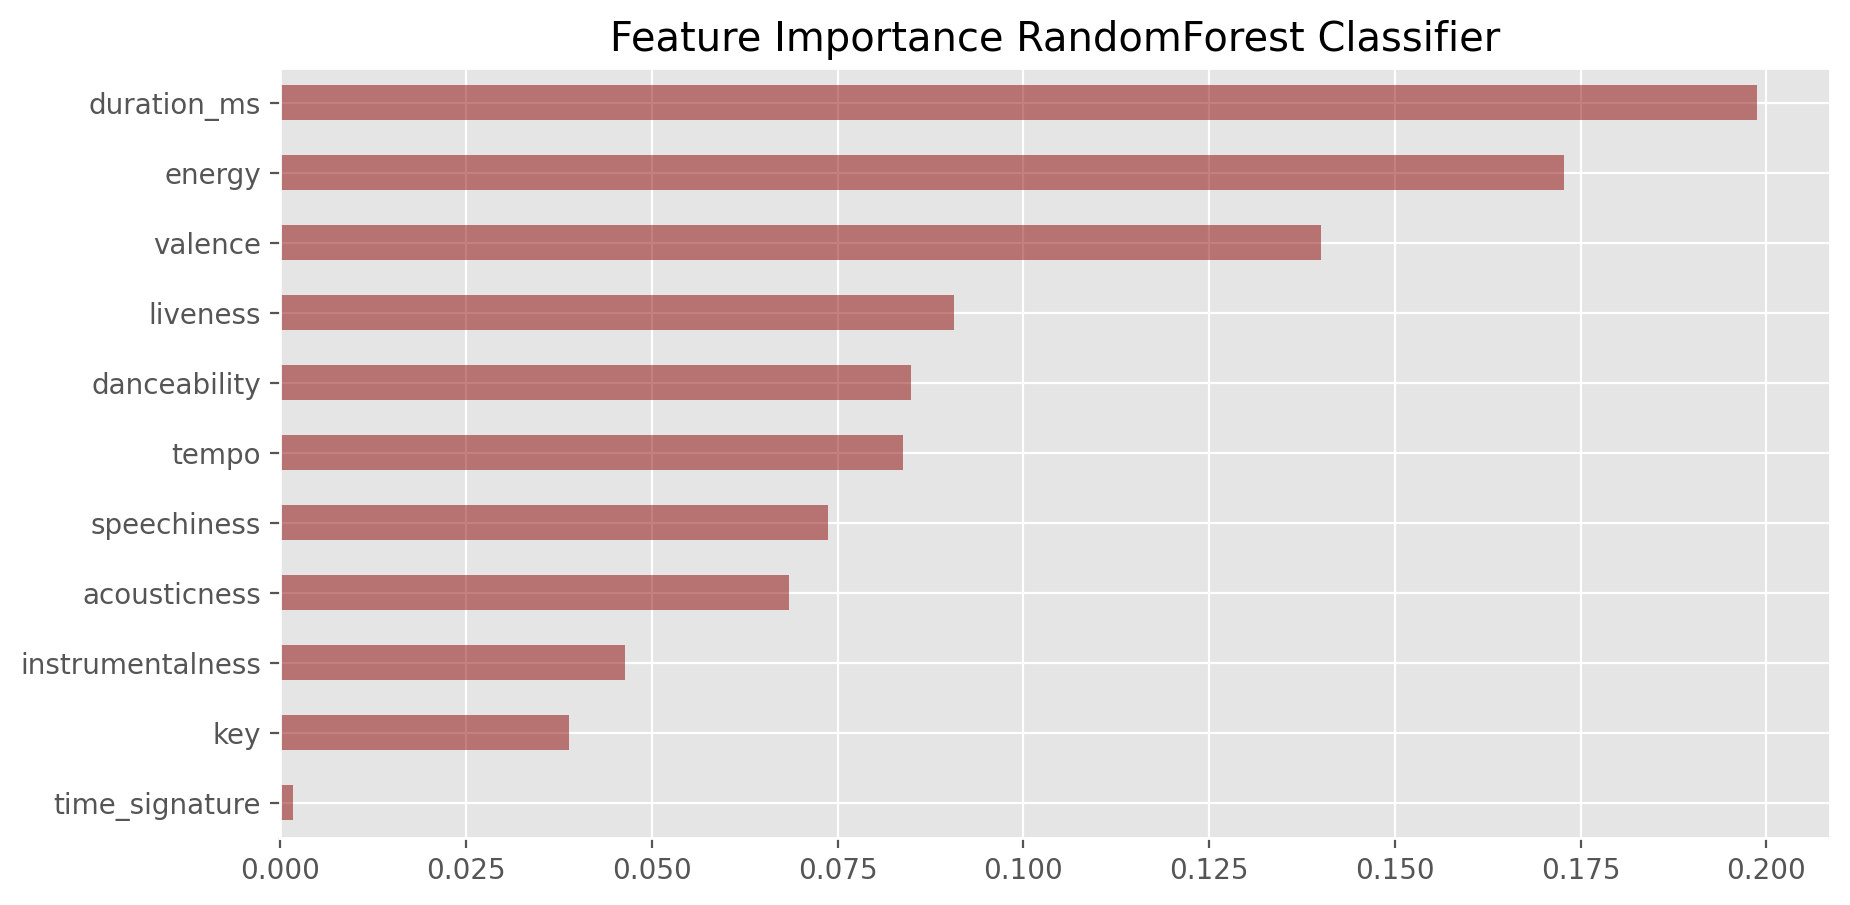

In [88]:
importance_series = pd.Series(data=rf.feature_importances_, index=X_validation_smote.columns)
ax = importance_series.sort_values().plot(kind='barh',width=0.5, figsize=(10,5), color='darkred', alpha=0.5)
ax.set_title('Feature Importance RandomForest Classifier');

9. The Feature Impact of LightGBM Classifier on model output is partly on the SHAP values. SHAP value shows us how much each feature individually contributes to the final prediction, negatively or positively.

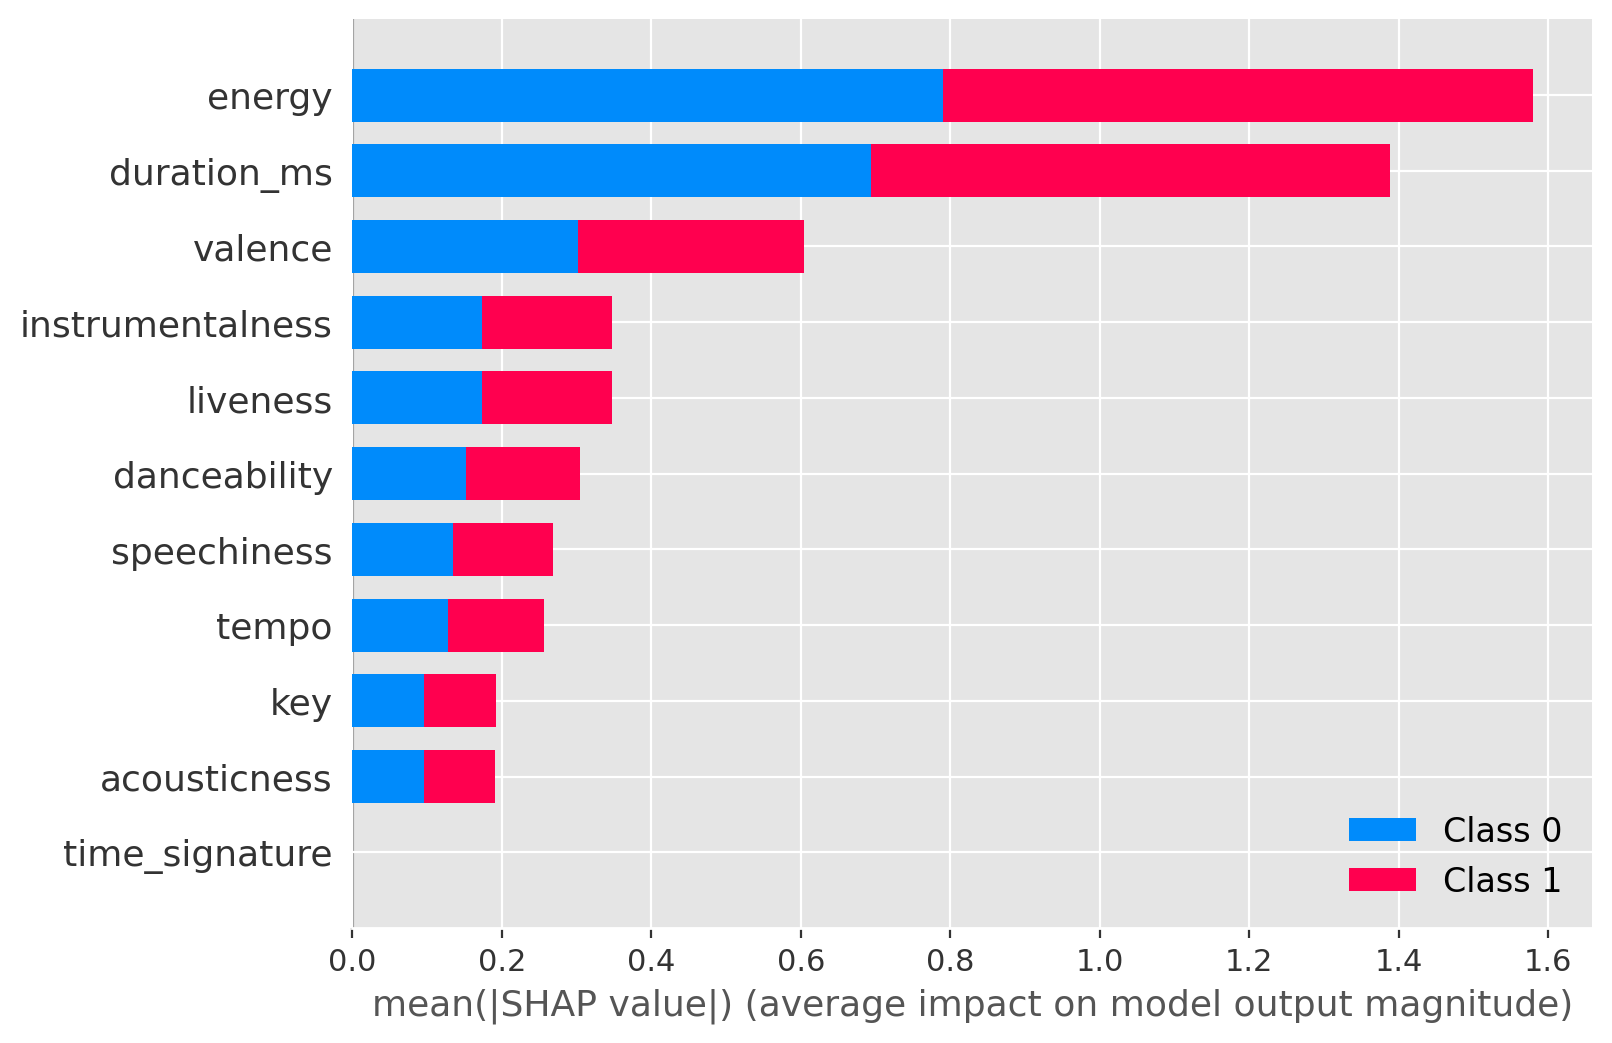

In [89]:
explainer = shap.TreeExplainer(lgb_c)
shap_values = explainer.shap_values(X_train_smote)

shap.summary_plot(shap_values, X_train_smote)

>The SHAP value is a mathematic calculation of how much each feature individually contributes to our machines  predicting if a certain song is by Blackpink or not.

>The left y-axis shows that the higher the features are on the list, the more impact they have on the model predicting whether a certain song is by Blackpink.

>Colors blue and red in the chart represent their feature value. For instance, the red dots represent the higher levels of speechiness and the blue represents the lower values speechiness.

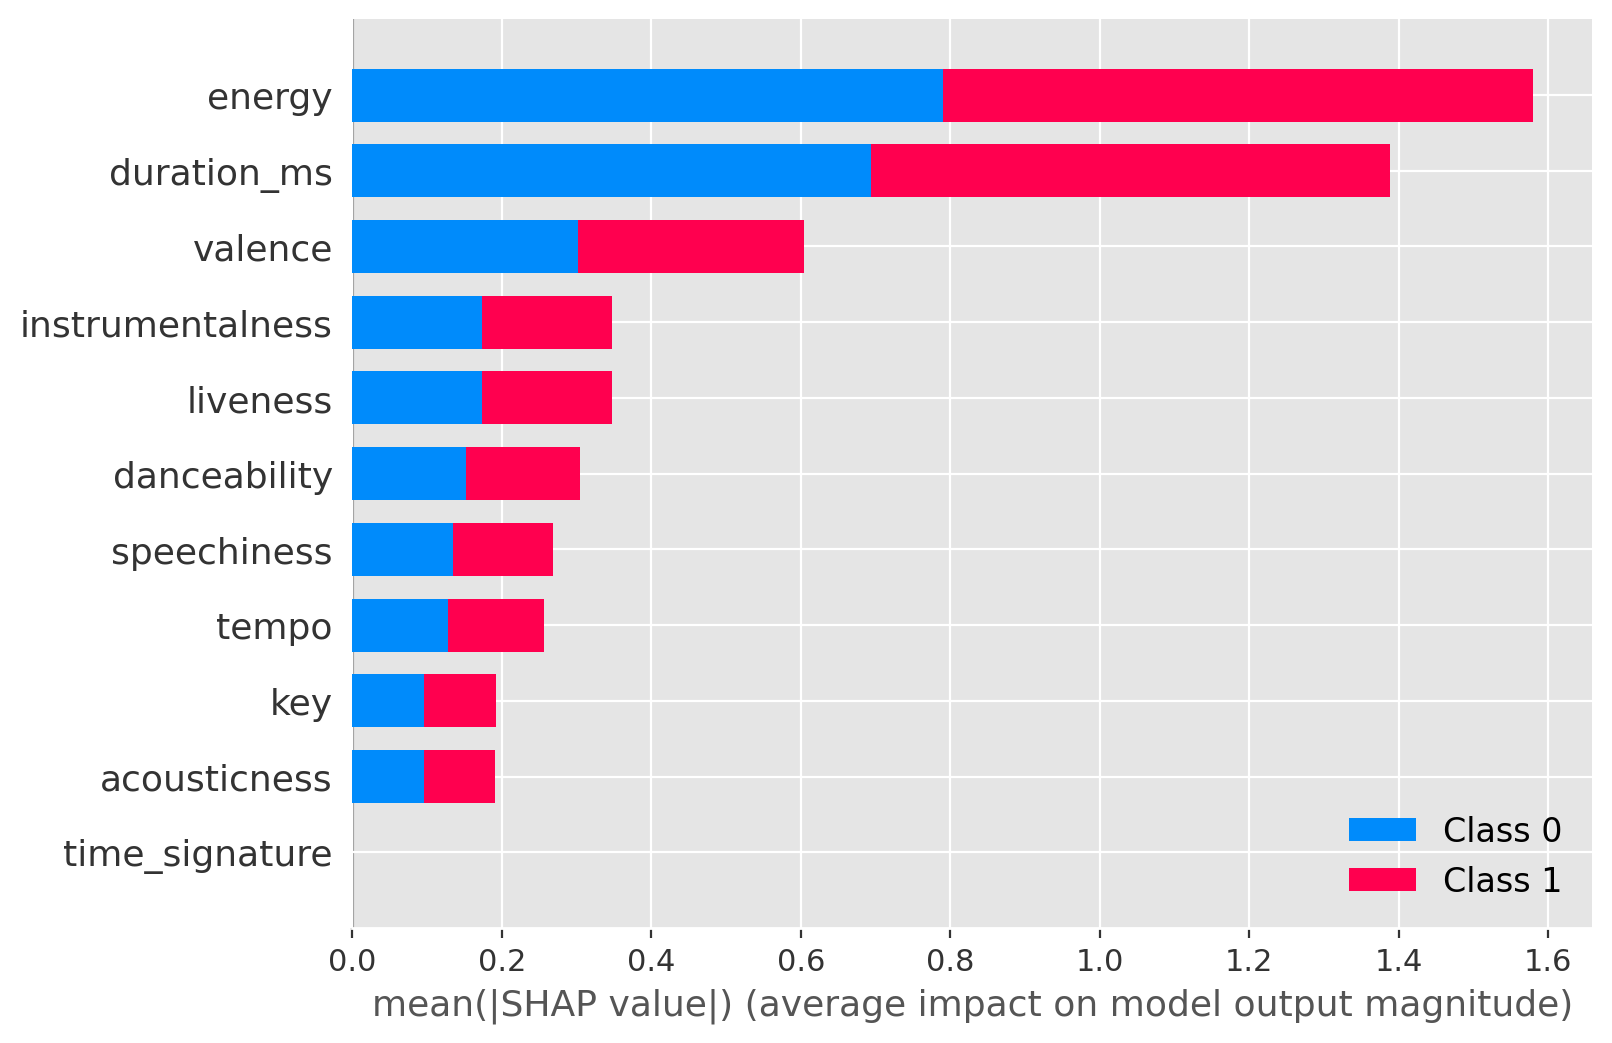

In [90]:
shap.summary_plot(shap_values, X_train_smote, plot_type = "bar")

In [91]:
apop_df = pd.read_csv('data/musical_data/merged_apop_song_features.csv', index_col = 0)

### Comparing Korean musical artists with American artists

How American pop musicians are different from Korean ones, especially compared to Blackpink.

In [92]:
blackpink = kpop_df_copy[kpop_df_copy.artist_name == 'blackpink']

merged_df = pd.concat([apop_df, blackpink], join = 'inner')

In [93]:
merged_df['target'] = [1 if i == 'blackpink' else 0 for i in merged_df.artist_name]

10. Calculation of the mean of the audio features of the groups

In [94]:
merged_df.groupby('artist_name').agg({'speechiness':'mean', 'instrumentalness':'mean', 'danceability':'mean', 'energy':'mean','acousticness':'mean'}).sort_values('speechiness', ascending = False)

,speechiness,instrumentalness,danceability,energy,acousticness
artist_name,,,,,
Christina Aguilera,0.108485,0.063259,0.612107,0.668288,0.238418
blackpink,0.095616,0.000055,0.675269,0.712017,0.136358
Lady Gaga,0.084522,0.015907,0.632386,0.705692,0.167523
Kelly Clarkson,0.082162,0.007363,0.551369,0.702889,0.166611
Rihanna,0.080839,0.011942,0.617027,0.675086,0.156436
Bruno Mars,0.073292,0.026226,0.647408,0.644171,0.238233
Katy Perry,0.061527,0.001338,0.632005,0.751266,0.088522
*NSYNC,0.058087,0.020642,0.606690,0.676935,0.224102
Backstreet Boys,0.054636,0.011073,0.609911,0.721334,0.138418


In [95]:
merged_df = merged_df.drop(['release_date','artist_name'],1)

11. Split 80% of the dataset for training and 20% for testing.

In [96]:
X_train, X_validation, y_train, y_validation = train_test_split(merged_df.iloc[:,:-1], merged_df.target, train_size=0.2)

X_train_lgbm = pd.get_dummies(X_train)
X_validation_lgbm = pd.get_dummies(X_validation)

X_train_lgbm.reset_index(inplace = True)
X_validation_lgbm.reset_index(inplace = True)

In [97]:
sm = SMOTE()

X_train_smote, y_train_smote = sm.fit_resample(X_train_lgbm, y_train.ravel())
X_validation_smote, y_validation_smote = sm.fit_resample(X_validation_lgbm, y_validation.ravel())

X_train_smote = pd.DataFrame(X_train_smote, columns = X_train_lgbm.columns).set_index('index')
X_validation_smote = pd.DataFrame(X_validation_smote, columns = X_validation_lgbm.columns).set_index('index')

12. Calculating the ROC AUC score with Gradient Boosting Classifier

In [98]:
gbc = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01)
gbc.fit(X_train_smote, y_train_smote)

validation_pred_proba_grad = gbc.predict_proba(X_validation_smote)
roc_auc_score(y_validation_smote, validation_pred_proba_grad[:,1])

0.9343218321400291

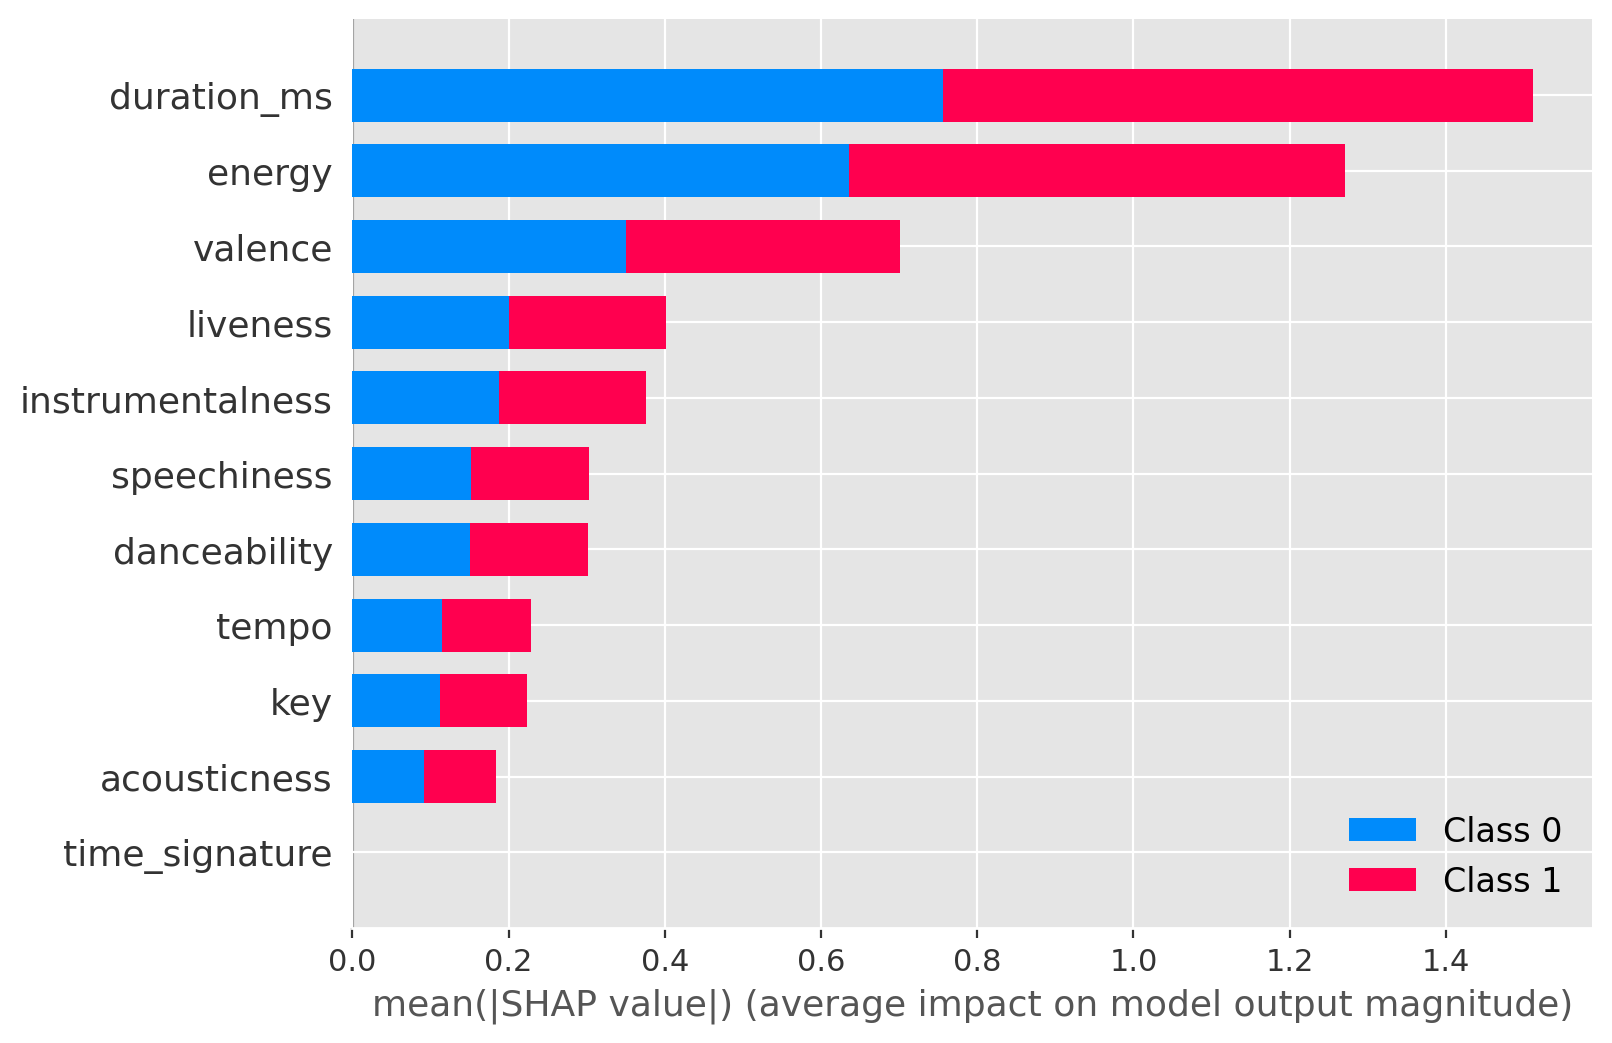

In [99]:
explainer = shap.TreeExplainer(lgb_c)
shap_values = explainer.shap_values(X_train_smote)

shap.summary_plot(shap_values, X_train_smote)